# Advanced-Lane-Lines
The goal of this project is to write a software pipeline to identify the lane boundaries in a video from a front-facing camera on a car.


The steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [1]:
import numpy as np
import cv2
import glob
import pickle
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from collections import deque
%matplotlib inline

## 1) Camera Calibration

In [ ]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

#Number of corners
nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

images_calib = glob.glob('./camera_cal/*.jpg')

for fname in images_calib:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        #img = cv2.drawChessboardCorners(img, (nx,ny), corners2,ret)
        #fig = plt.figure()
        #plt.imshow(img)
        #plt.title('Camera calibration')
        
# Perform the camera calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
        
# Create a dictionary with camera info        
calibration_info = { "ret": ret, "mtx": mtx, "dist": dist, "rvecs": rvecs,
"tvecs": tvecs }

# Save camera calibration info in a file
pickle.dump( calibration_info, open( "calib_info.p", "wb" ) )


## 2) Distortion correction

In [2]:
# Remove distortion from images
def undistort(img, mtx, dist, show=False):

    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    if show:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB) )
        ax1.set_title('Original Image')
        ax2.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted Image')
    
    return undist    

### Example distortion correction on images

In [3]:
# Load calibration info
cal_pickle = pickle.load( open("calib_info.p", "rb" ) )
mtx_l = cal_pickle["mtx"]
dist_l = cal_pickle["dist"]

### Test undistort on chessboard picture

In [ ]:
    # Lead test image
    img = cv2.imread('./camera_cal/calibration1.jpg')
    # Undistor image
    undistort(img,mtx_l, dist_l, show=True)

In [ ]:
images_list = glob.glob('./test_images/*.jpg')

for fname in images_list:
    img = cv2.imread(fname)
    undistort(img,mtx_l, dist_l, show=True)
    

# Define Mask to detect lines

In [4]:
# Masks the image based on gradient absolute value.
def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output


# Masks the image based on gradient magnitude.
def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

# Masks the image based on gradient direction.
def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    return binary_output

def color_threshold_hls(image, s_thresh=(100,255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]

    s_binary = np.zeros_like(S)
    s_binary[(S >= s_thresh[0]) & (S <= s_thresh[1])] = 1
    #plt.figure()
    #plt.imshow(s_binary)
    #plt.title('hls')
    
    return s_binary

def color_threshold_luv(image, l_thresh=(100,255)):
    l = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)[:,:,0]

    #plt.figure()
    #plt.imshow(l,cmap='gray')
    #plt.title('luv- l channel')
    s_binary = np.zeros_like(l)
    s_binary[(l >= l_thresh[0]) & (l <= l_thresh[1])] = 1
    #plt.figure()
    #plt.imshow(s_binary,cmap='gray')
    #plt.title('luv')
    
    return s_binary


def color_treshold_lab(image, b_thresh, l_thresh):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)
    b_channel = lab[:,:,2]
    l_channel = lab[:,:,0]
    #plt.figure()
    #plt.imshow(l_channel,cmap='gray')
    #plt.title('lab-l channel')
    #plt.figure()
    #plt.imshow(b_channel,cmap='gray')
    #plt.title('lab-b channel')
               
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <=  l_thresh[1])] = 1
    #plt.figure()
    #plt.imshow(l_binary,cmap='gray')
    #plt.title('lab-l threshold')
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh[0]) & (b_channel <=  b_thresh[1])] = 1
    #plt.figure()
    #plt.imshow(b_binary,cmap='gray')
    #plt.title('lab-b threshold')    
    combined_binary = np.zeros_like(b_channel)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1
    #plt.figure()
    #plt.imshow(combined_binary,cmap='gray')
    #plt.title('lab - l and b combined')

    return combined_binary

def get_mask(image, ksize=3, show = False):
    

    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    #image_blur = cv2.GaussianBlur(image, (3, 3), 0)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:, :, 2]
    #plt.figure()
    #plt.imshow(s_channel)
    #plt.title('s_channel')
    
    gradx = abs_sobel_thresh(s_channel, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(s_channel, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    #plt.figure()
    #plt.imshow(gradx)
    #plt.title('gradx')
    mag_binary = mag_thresh(s_channel, sobel_kernel=ksize, mag_thresh=(20, 100))
    #plt.figure()
    #plt.imshow(mag_binary)
    #plt.title('mag_binary')
    dir_binary = dir_threshold(s_channel, sobel_kernel=ksize, thresh=(0.7, 1.3))
    #plt.figure()
    #plt.imshow(dir_binary)
    #plt.title('dir_binary')
    g_combined = np.zeros_like(dir_binary)
    g_combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    #g_combined[(gradx == 1)  | ((mag_binary == 1) & (dir_binary == 1))] = 1
    #plt.figure()
    #plt.imshow(g_combined)
    #plt.title('gradient mask before')
    kernel = np.ones((5,5),np.uint8)
    g_combined = cv2.morphologyEx(g_combined, cv2.MORPH_OPEN, kernel)
    #plt.figure()
    #plt.imshow(g_combined,cmap='gray')
    #plt.title('gradient mask')
    
    
    #color_binary_hsl = color_threshold_hls(image, s_thresh=(200,255))
    color_binary_luv = color_threshold_luv(image, l_thresh=(210,255))
    color_binary_lab = color_treshold_lab(image, b_thresh=(155,255), l_thresh=(230,255))
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(dir_binary)
    combined_binary[(color_binary_luv == 1) | (color_binary_lab == 1)] = 1
    
    
        
    all_combined = np.zeros_like(image[:,:,0])
    #g_combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    all_combined[(g_combined == 1)  | (combined_binary == 1) ] = 1

    
    return all_combined, combined_binary



In [ ]:
images_list = glob.glob('./test_images/*.jpg')

for fname in images_list:
    image = mpimg.imread(fname)
    plt.figure()
    plt.imshow(image)
    plt.title('image')
    image = undistort(image, mtx_l, dist_l, show=False)
    all_combined, color_binary_lab = get_mask(image)
    plt.figure()
    plt.imshow(all_combined)
    plt.title('result',cmap='gray')  
 
    
        
    

In [ ]:
image = mpimg.imread('./test_images/test5.jpg')
plt.figure()
plt.imshow(image)
plt.title('image')
image = undistort(image, mtx_l, dist_l, show=False)
all_combined, color_binary_lab, gradient = get_mask(image)
plt.figure()
plt.imshow(all_combined,cmap='gray')
plt.title('result')  
plt.figure()
plt.imshow(color_binary_lab,cmap='gray')
plt.title('color')  
plt.figure()
plt.imshow(gradient,cmap='gray')
plt.title('gradient')  
 

# Test the masks

In [ ]:
#image = mpimg.imread('test_images/test1.jpg')

images_list = glob.glob('./test_images/*.jpg')

for fname in images_list:
    image = mpimg.imread(fname)
    image = undistort(image, mtx_l, dist_l, show=False)
    result_g, result_c = get_mask(image, ksize=3 )

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    #f.tight_layout()
    ax1.axis('off')
    ax1.imshow(image)
    ax1.set_title('result_g', fontsize=18)
    ax2.axis('off')
    ax2.imshow(result_g)
    ax2.set_title('All', fontsize=18)

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    #f.tight_layout()
    ax1.axis('off')
    ax1.imshow(image)
    ax1.set_title('Original', fontsize=18)
    ax2.axis('off')
    ax2.imshow(result_c)
    ax2.set_title('Color segmentation', fontsize=18)




# Perspective Transform

In [34]:
def perspective_transform(gray, mtx_l, dist_l):

    # Convert undistorted image to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Grab the image shape
    img_size = (gray.shape[1], gray.shape[0])
    (h, w) = (gray.shape[0], gray.shape[1])
    # Define source points and destination 
    src = np.float32([[  564. ,  450.],[716. ,  450.],[ -100. ,  720.],[ 1380. ,  720.]])
    dst = np.float32([[  100. , 0.],[1180. ,   0.],[100.  , 720.],[ 1180. ,  720.]])
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(gray, M, img_size)

    # Return the resulting image and matrix
    return warped, M, Minv


## Test perspective transform

[[  564.   450.]
 [  716.   450.]
 [ -100.   720.]
 [ 1380.   720.]]
[[  100.     0.]
 [ 1180.     0.]
 [  100.   720.]
 [ 1180.   720.]]
[[  564.   450.]
 [  716.   450.]
 [ -100.   720.]
 [ 1380.   720.]]
[[  100.     0.]
 [ 1180.     0.]
 [  100.   720.]
 [ 1180.   720.]]
[[  564.   450.]
 [  716.   450.]
 [ -100.   720.]
 [ 1380.   720.]]
[[  100.     0.]
 [ 1180.     0.]
 [  100.   720.]
 [ 1180.   720.]]
[[  564.   450.]
 [  716.   450.]
 [ -100.   720.]
 [ 1380.   720.]]
[[  100.     0.]
 [ 1180.     0.]
 [  100.   720.]
 [ 1180.   720.]]
[[  564.   450.]
 [  716.   450.]
 [ -100.   720.]
 [ 1380.   720.]]
[[  100.     0.]
 [ 1180.     0.]
 [  100.   720.]
 [ 1180.   720.]]
[[  564.   450.]
 [  716.   450.]
 [ -100.   720.]
 [ 1380.   720.]]
[[  100.     0.]
 [ 1180.     0.]
 [  100.   720.]
 [ 1180.   720.]]
[[  564.   450.]
 [  716.   450.]
 [ -100.   720.]
 [ 1380.   720.]]
[[  100.     0.]
 [ 1180.     0.]
 [  100.   720.]
 [ 1180.   720.]]
[[  564.   450.]
 [  716.   450.]


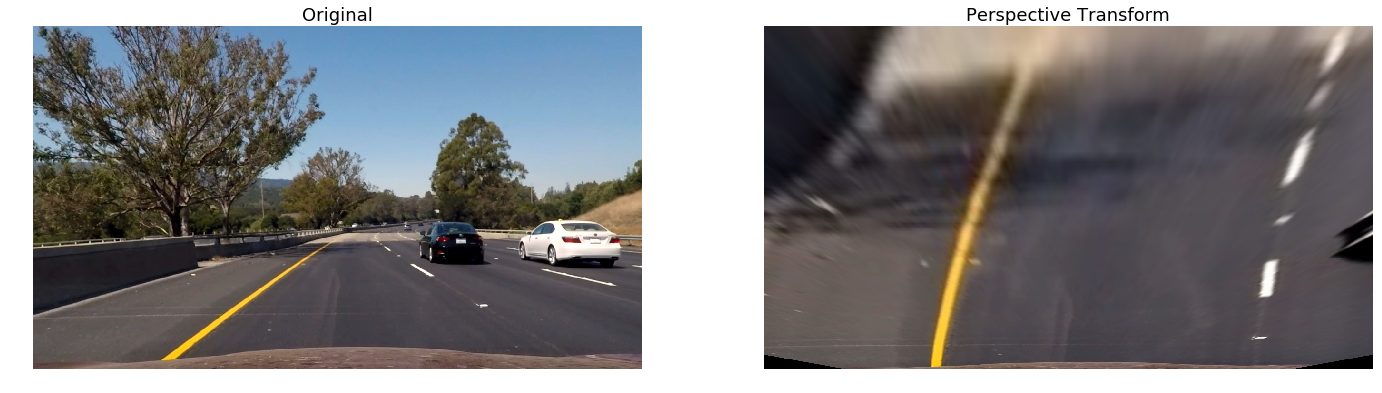

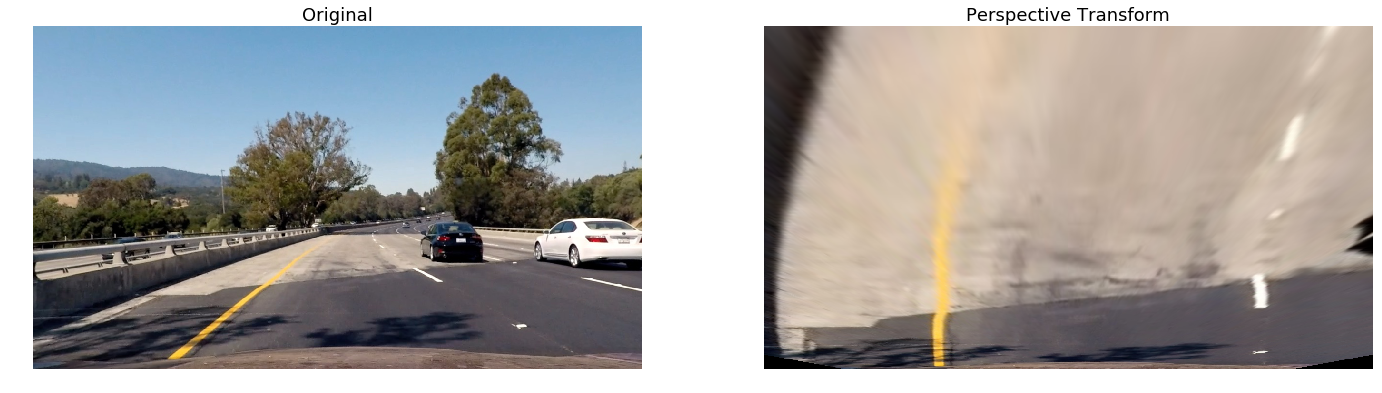

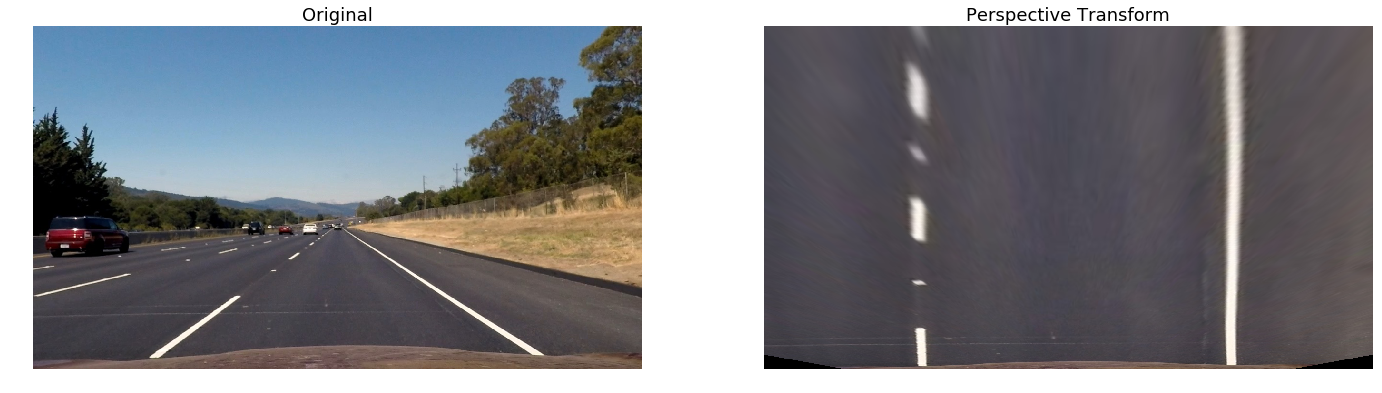

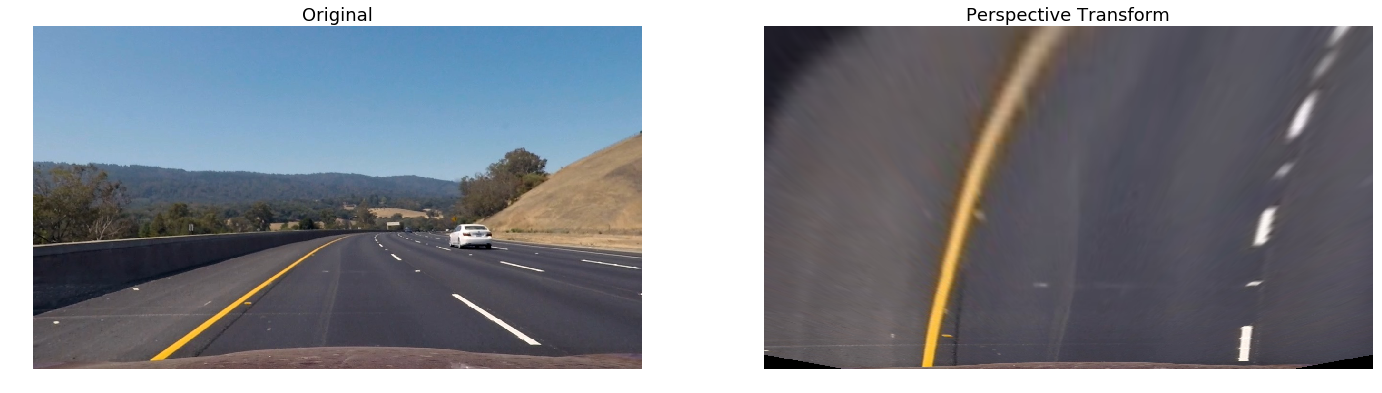

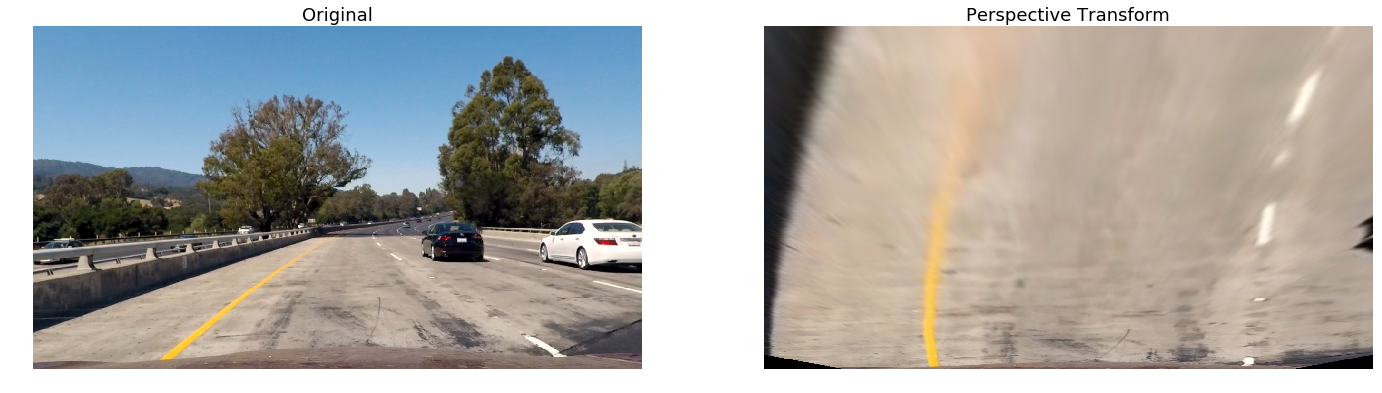

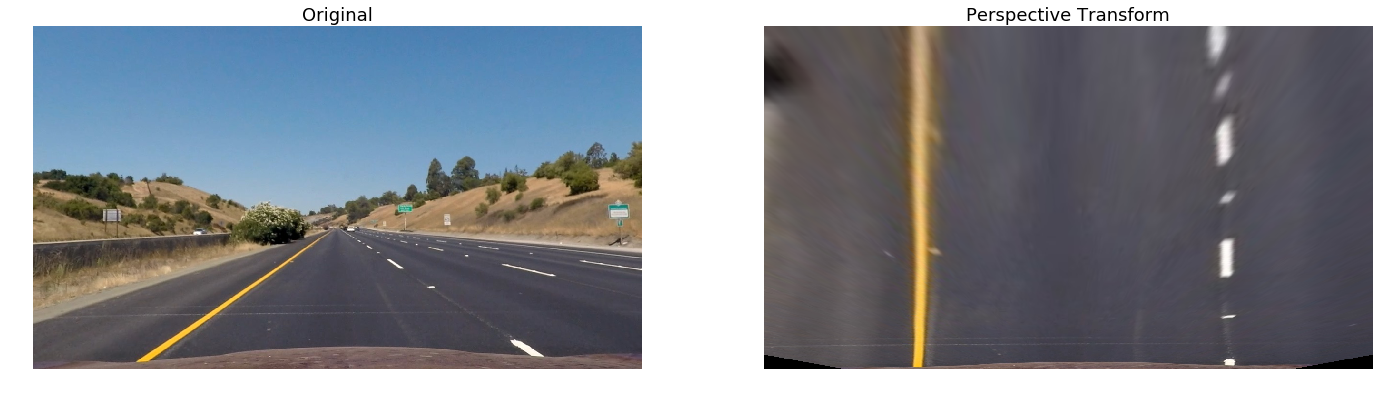

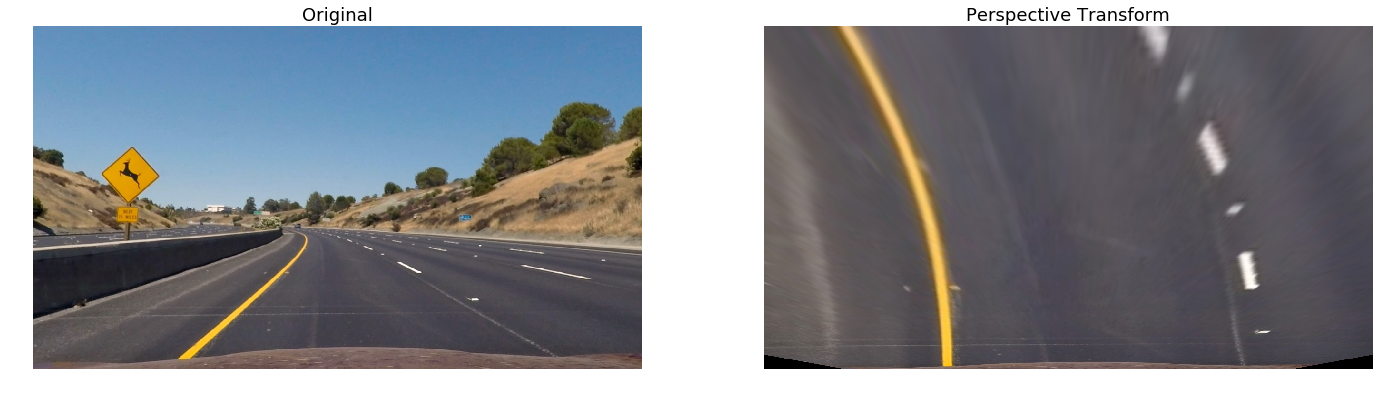

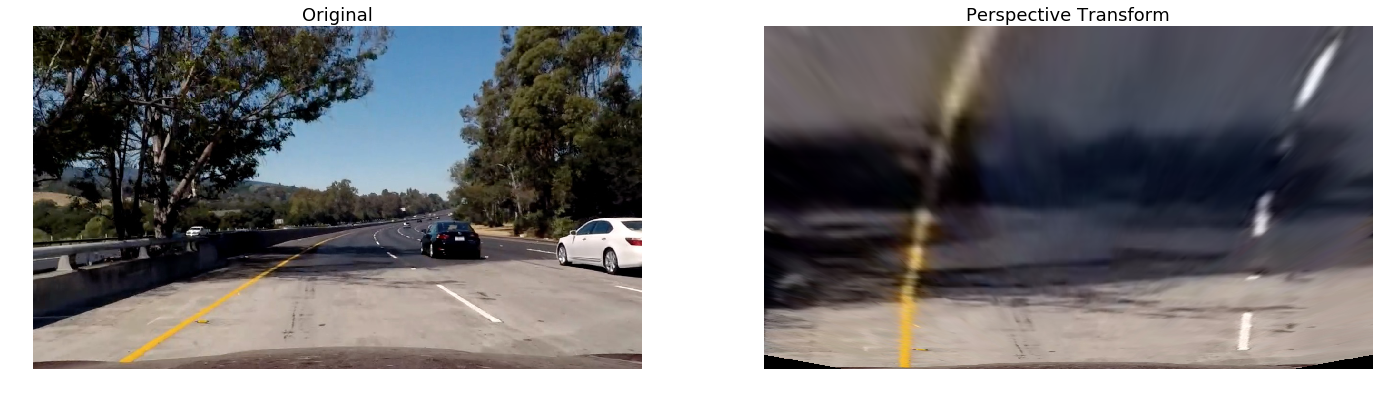

In [30]:
images_list = glob.glob('./test_images/*.jpg')

for fname in images_list:
  
    image = mpimg.imread(fname)
    image = undistort(image, mtx_l, dist_l, show=False)
    
    #result_g, result_c = get_mask(image)
    
    result,M,Minv = perspective_transform(image, mtx_l, dist_l)

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    #f.tight_layout()
    ax1.axis('off')
    ax1.imshow(image)
    ax1.set_title('Original', fontsize=18)
    ax2.axis('off')
    ax2.imshow(result)
    ax2.set_title('Perspective Transform', fontsize=18)
    #plt.figure()
    #histogram = np.sum(result[result.shape[0]//2:,:], axis=0)
    #plt.plot(histogram)



## Line Finding Method: Peaks in a Histogram

In [43]:
def find_lanes(binary_warped, nwindows = 9):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    plt.figure()

    plt.plot(histogram)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return out_img, left_fitx, right_fitx, leftx, lefty, rightx, righty, ploty 


def draw_lines(image, binary_warped, left_fitx, right_fitx, ploty, Minv ):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    return result

## Pipeline test on images

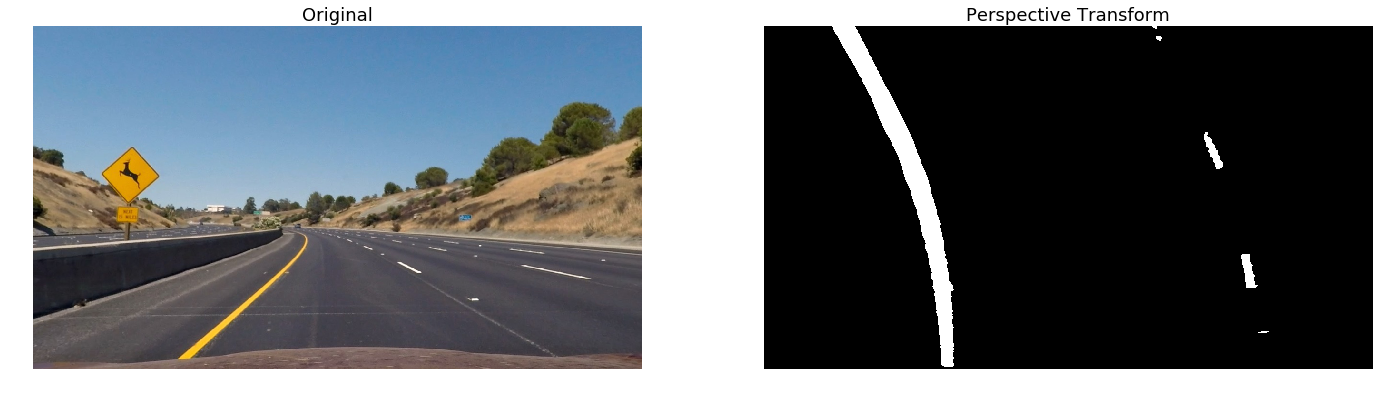

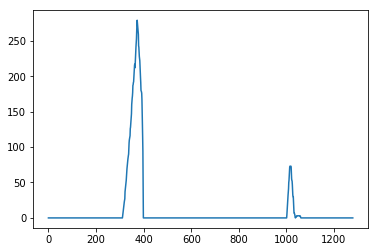

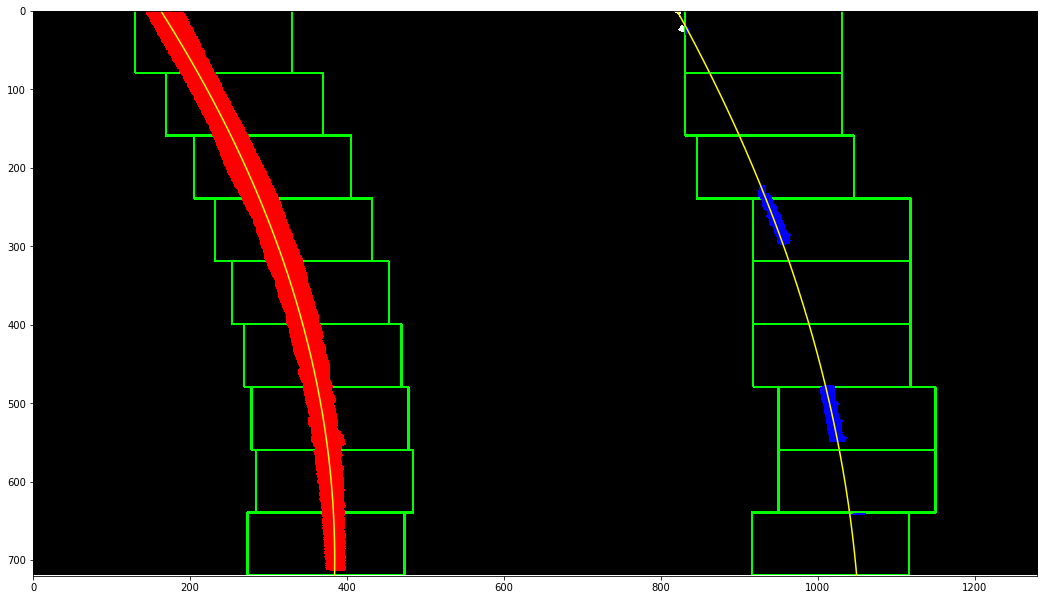

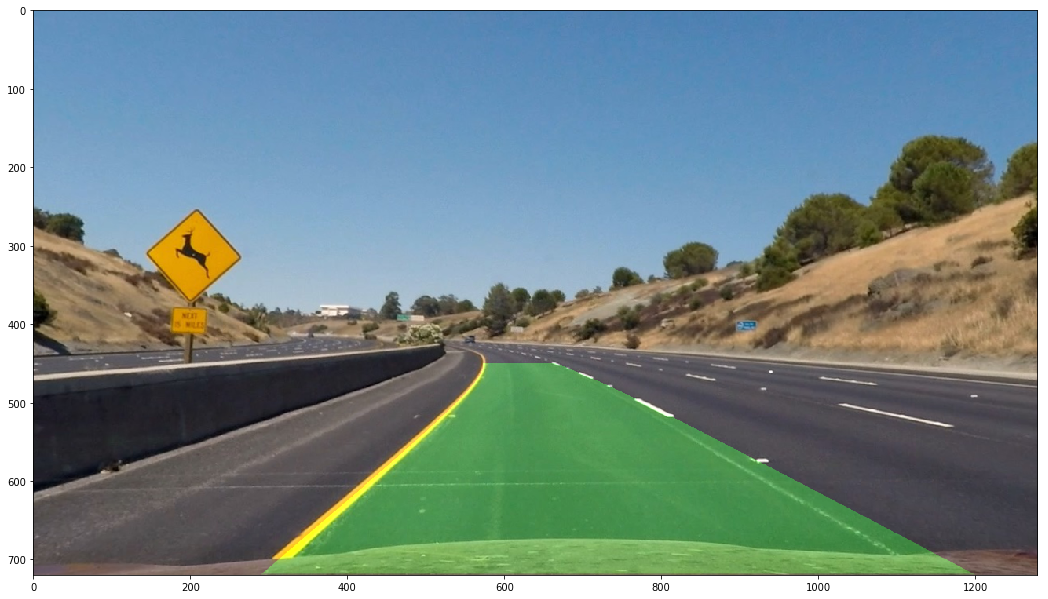

In [44]:
# Read image
image = mpimg.imread("test_images/test2.jpg")
# Undistort image
image = undistort(image, mtx_l, dist_l, show=False)

# Apply perspective transform
warped, M, Minv = perspective_transform(image, mtx_l, dist_l)
# Get the mask 
result_g, result_c = get_mask(warped)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
#f.tight_layout()
ax1.axis('off')
ax1.imshow(image)
ax1.set_title('Original', fontsize=18)
ax2.axis('off')
ax2.imshow(result_g,cmap='gray')
ax2.set_title('Perspective Transform', fontsize=18)

# Find lanes
out_img, left_fitx, right_fitx, leftx, lefty, rightx, righty, ploty  = find_lanes(result_g)

# Plot Result
plt.figure(figsize=(18,18))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

# Reproject polygon on the original image
result = draw_lines(image, binary_warped, left_fitx, right_fitx, ploty, Minv )
plt.figure(figsize=(18,18))
plt.imshow(result)

# Test on Video

In [18]:
import collections

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self, isleft):
        self.isleft = isleft
        # was the line detected in the last iteration?
        self.detected = False 
        # second order polynomial 
        self.fit = None
        # Actual second order polynomial
        self.fit_actual = None
        # polygon points
        self.line_pts = []
        # line to draw
        self.line_draw = []
        # Queue with last detections
        self.fit_past = collections.deque(maxlen=10)
        # Frame counter:
        self.count = 0
        # Radius for display
        self.radius_disp = 0
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = 0 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
        
    def blind_search(self, binary_warped, out_img, nwindows = 9):
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
        #plt.figure()

        #plt.plot(histogram)
        # Create an output image to draw on and  visualize the result
        #out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        if (self.isleft):
            x_base = np.argmax(histogram[:midpoint])
        else:
            x_base = np.argmax(histogram[midpoint:]) + midpoint

        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        x_current = x_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_x_low = x_current - margin
            win_x_high = x_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_x_low,win_y_low),(win_x_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_x_low) & (nonzerox < win_x_high)).nonzero()[0]
            # Append these indices to the lists
            lane_inds.append(good_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_inds) > minpix:
                x_current = np.int(np.mean(nonzerox[good_inds]))


        # Concatenate the arrays of indices
        lane_inds = np.concatenate(lane_inds)

        # Extract left and right line pixel positions
        x = nonzerox[lane_inds]
        y = nonzeroy[lane_inds] 

        if np.sum(x) > 0: 
            # Fit a second order polynomial 
            self.fit = np.polyfit(y, x, 2)

            # Generate x and y values for plotting
            ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
            fitx = self.fit[0]*ploty**2 + self.fit[1]*ploty + self.fit[2]

            if (self.isleft):
                out_img[nonzeroy[lane_inds], nonzerox[lane_inds]] = [255, 0, 0]
            else:
                out_img[nonzeroy[lane_inds], nonzerox[lane_inds]] = [0, 0, 255]
            self.detected = True

            return fitx, x, y, ploty 
        else:
            self.detected = False # If no lane pixels were detected then perform blind search
            self.fit_past = []
            self.fit = []
            fitx = []
            x = []
            y = []
            ploty = []
            return fitx, x, y, ploty        
    
    def found_search(self, binary_warped, out_img):
    
        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        lane_inds = ((nonzerox > (self.fit[0]*(nonzeroy**2) + self.fit[1]*nonzeroy + self.fit[2] - margin)) & (nonzerox < (self.fit[0]*(nonzeroy**2) + self.fit[1]*nonzeroy + self.fit[2] + margin))) 

        # Again, extract left and right line pixel positions
        x = nonzerox[lane_inds]
        y = nonzeroy[lane_inds] 
        
        if np.sum(x) > 0: 
            # Fit a second order polynomial
            self.fit = np.polyfit(y, x, 2)
            self.fit_actual = self.fit
            self.fit_past.append(self.fit)
            self.fit = np.array(self.fit_past).sum(axis=0)
            self.fit = self.fit/len(self.fit_past)
            
            # Generate x and y values for plotting
            ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
            fitx = self.fit[0]*ploty**2 + self.fit[1]*ploty + self.fit[2]

            #window_img = np.zeros_like(out_img)
            # Color in left and right line pixels
            if (self.isleft):
                out_img[nonzeroy[lane_inds], nonzerox[lane_inds]] = [255, 0, 0]
            else:
                out_img[nonzeroy[lane_inds], nonzerox[lane_inds]] = [0, 0, 255]

            # Generate a polygon to illustrate the search window area
            # And recast the x and y points into usable format for cv2.fillPoly()
            line_window1 = np.array([np.transpose(np.vstack([fitx-margin, ploty]))])
            line_window2 = np.array([np.flipud(np.transpose(np.vstack([fitx+margin, ploty])))])
            self.line_pts = np.hstack((line_window1, line_window2))
            
            fitx_actual = self.fit_actual[0]*ploty**2 + self.fit_actual[1]*ploty + self.fit_actual[2]

            line_window1 = np.array([np.transpose(np.vstack([fitx_actual-2, ploty]))])
            line_window2 = np.array([np.flipud(np.transpose(np.vstack([fitx_actual+2, ploty])))])
            self.line_draw = np.hstack((line_window1, line_window2))
            
            return fitx, x, y, ploty
        else:
            self.detected = False # If no lane pixels were detected then perform blind search
            self.fit_past = []
            self.fit = []
            fitx = []
            x = []
            y = []
            ploty = []
            return fitx, x, y, ploty


        
def compute_radius_offset(leftx, lefty, rightx, righty, shape):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]* shape[0]*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]* shape[0]*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    # Offset from center
    offset_px = (leftx[-1] + rightx[-1])/2 - 640
    offset_m = offset_px*3.7/670
        
    return left_curverad, right_curverad, offset_m

       
def sanity_check(right_line, left_line, right_fitx,left_fitx, ploty, leftx, lefty, rightx, righty):
    pl_bot_real = (leftx[-1], lefty[-1])
    pr_bot_real = (rightx[-1], righty[-1])
    pl_top_real = (leftx[0], lefty[0])
    pr_top_real = (rightx[0], righty[0]) 

    pl_top = (right_fitx[0], ploty[0])
    pr_top = (left_fitx[0], ploty[0])
    pl_bot = (right_fitx[-1], ploty[-1])
    pr_bot = (left_fitx[-1], ploty[-1])     

    dist_bottom =  distance(pl_bot, pr_bot)
    dist_top =  distance(pl_top, pr_top)
    
    if abs(dist_bottom - dist_top) > 100:
        right_line.fit = right_line.fit_past[-1]
        left_line.fit = left_line.fit_past[-1]
    
    return pl_bot, pr_bot, pl_top, pr_top         



def distance(p0, p1):
    return math.sqrt((p0[0] - p1[0])**2 + (p0[1] - p1[1])**2)




def draw_line_polygon(out_img, right_line_pts, left_line_pts, color = (0,255, 0)):
    window_img = np.zeros_like(out_img)
    if (len(left_line_pts)):
        cv2.fillPoly(window_img, np.int_([left_line_pts]), color)
    if (len(right_line_pts)):
        cv2.fillPoly(window_img, np.int_([right_line_pts]), color)
    return window_img
        


In [23]:
def process_image(image):
    
    #image = undistort(image, mtx_l, dist_l, show=False)
    
    #binary_warped, M, Minv = perspective_transform(image, mtx_l, dist_l)    
    #binary_warped, result_c = get_mask(binary_warped)
    
    image = undistort(image, mtx_l, dist_l, show=False)
    result_g, result_c = get_mask(image)

    binary_warped, M, Minv = perspective_transform(result_g, mtx_l, dist_l)




    # Find lanes
    #out_img, left_fitx, right_fitx, leftx, lefty, rightx, righty, ploty  = find_lanes(binary_warped)
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    if (left_line.detected == True):
        left_fitx, left_x, left_y, ploty  = left_line.found_search(binary_warped, out_img)
        
    if (left_line.detected == False):
        left_fitx, left_x, left_y, ploty  = left_line.blind_search(binary_warped, out_img)
        
    if (right_line.detected == True):
        right_fitx, right_x, right_y, ploty = right_line.found_search(binary_warped, out_img)
        
    if (right_line.detected == False):
        right_fitx, right_x, right_y, ploty = right_line.blind_search(binary_warped, out_img)
     
    if (right_line.detected & left_line.detected):
        # Get radius and offset
        left_radius, right_radius, offset = compute_radius_offset(left_x, left_y, right_x, right_y, image.shape)

        # Draw lines
        window_img = draw_line_polygon(out_img, right_line.line_pts, left_line.line_pts, color = (0,255, 0))
        out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        window_img = draw_line_polygon(out_img, right_line.line_draw, left_line.line_draw, color = (255,255, 0))
        out_img = cv2.addWeighted(out_img, 1, window_img, 0.9, 0)
        
        pl_bottom, pr_bottom, pl_top, pr_top = sanity_check(right_line, left_line, right_fitx,left_fitx, ploty, left_x, left_y, right_x, right_y)
        #cv2.circle(out_img, pl_bottom,1,(255,255,255),36);
        #cv2.circle(out_img, pr_bottom,1,(255,255,255),36);
        #cv2.circle(out_img, pl_top,1,(255,255,255),36);
        #cv2.circle(out_img, pr_top,1,(255,255,255),36);
        #cv2.circle(out_img, (int(right_fitx[0]),int(ploty[0])),1,(255,255,255),36);
        #cv2.circle(out_img, (int(left_fitx[0]),int(ploty[0])),1,(255,255,0),36);
        #cv2.circle(out_img, (int(right_fitx[-1]),int(ploty[-1])),1,(255,255,255),36);
        #cv2.circle(out_img, (int(left_fitx[-1]),int(ploty[-1])),1,(255,255,255),36);
        
        # Draw result on the original image
        result = draw_lines(image, binary_warped, left_fitx, right_fitx, ploty, Minv)

        out_img_small = cv2.resize(out_img, (int(out_img.shape[1]/3.5),int(out_img.shape[0]/3.5)))

        x_offset=20
        y_offset=20
        result[y_offset:y_offset+out_img_small.shape[0], x_offset:x_offset+out_img_small.shape[1]] = out_img_small

        prev_radius = int((left_line.radius_of_curvature+right_line.radius_of_curvature)/2)
        radius = int((left_radius+right_radius)/2)
        radius = int((radius+prev_radius)/2)

        if left_line.count % 3 == 0:
            left_line.radius_disp = radius

        if left_line.count > 5:    
            cv2.putText(result, 'Radius of curvature of the lane  {}(m)'.format(left_line.radius_disp), (540,x_offset*4),fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 2) 
            cv2.putText(result, 'Offset from center  {}(m)'.format(round(offset,3)), (540, x_offset*6),fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 2) 
        left_line.radius_of_curvature = left_radius
        right_line.radius_of_curvature = right_radius
        left_line.count += 1
    else:
        result = image
    
    return result

In [24]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

#del left_line
#del right_line

left_line = Line(True)
right_line = Line(False)

output = 'project_video_output_inverted_points_new_a.mp4'
clip2 = VideoFileClip('project_video.mp4')
output_clip = clip2.fl_image(process_image)
%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output_inverted_points_new_a.mp4
[MoviePy] Writing video project_video_output_inverted_points_new_a.mp4


100%|█████████▉| 1260/1261 [05:32<00:00,  3.75it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output_inverted_points_new_a.mp4 

CPU times: user 33min 57s, sys: 9.61 s, total: 34min 6s
Wall time: 5min 33s


In [25]:

from IPython.display import HTML
video_output = 'project_video_output_inverted_points_new_a.mp4'
print(video_output)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

project_video_output_inverted_points_new_a.mp4


In [ ]:
histogram.shape

In [ ]:
image = mpimg.imread("test_images/test5.jpg")
image = undistort(image, mtx_l, dist_l, show=False)
result_g, result_c = get_mask(image)


print(image.shape)

binary_warped, M, Minv = perspective_transform(result_c, mtx_l, dist_l)

# Find lanes
#out_img, left_fitx, right_fitx, leftx, lefty, rightx, righty, ploty  = find_lanes(binary_warped)

left_fitx, left_x, left_y, ploty  = left_line.blind_search(binary_warped)